<a href="https://colab.research.google.com/github/akitim/comptech-winter-school-2022_covid19-prediction/blob/main/Comptech_val_eng_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [89]:
!pip install httpx

In [90]:
import pandas as pd
import itertools
from scipy.signal import savgol_filter
from tqdm.notebook import tqdm
import json
from collections import defaultdict
import pickle
from matplotlib import pyplot as plt
import pickle
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error as mape, mean_absolute_error as mae
import statsmodels.api as sm
from datetime import date, timedelta
import pickle
import httpx
import json
import warnings
warnings.filterwarnings('ignore')

In [91]:
def get_cases(days):
  data = httpx.get(f"https://storage.yandexcloud.net/covid-19/cases{\
      ('_' + str(days)) if days != 0 else ''}.pickle").content
  return pickle.loads(data)

In [92]:
def get_lags(days):
  data = httpx.get(f"https://storage.yandexcloud.net/covid-19/lags{\
      ('_' + str(days)) if days != 0 else ''}.json").content
  return json.loads(data)

In [93]:
def median_percentage_absolute_error(y_true, y_pred):
    return np.round(np.median(np.abs((y_true - y_pred) / y_true)), 6)

In [94]:
def get_columns(country, top_3_countries, num_features):
  first = [f"{country}_{i}" for i in range(1, 31)]
  second = []
  for c, _ in top_3_countries:
    for i in range(1, num_features + 1):  
      second.append(f"{c}_{i}")
  second.append('y')
  return first + second


def get_predict_linregr(country, lags, need_predict, cases_all, use_filter=True, num_features=30):

  field_name = ("filtered_" if use_filter else "") + "history"
  threshold = date(year=2021, month=1, day=1)

  # PREPARE TRAIN DATA
  a = cases_all[country][field_name] #случаи по стране cглаженные или нет
  a = a[a.index >= threshold] #отсечение - берем даты после 01.01.2021
  df_list = []
  top_3_countries = [
    i for i in sorted(lags[country].items(),
                        key=lambda x: x[1]["similarity"]
                      ) if -i[1]["lag"] > need_predict
    ][-3:] #топ-3 страны с максимальной корреляцией

  for window in range(num_features, (a.index[-1] - threshold).days): # window проходит значения от кол-ва пр-ков до кол-ва дней в рассм. cases
    this_row = list(a[window - num_features : window].values)
    y = a[window]

    for country_similar, info in top_3_countries:

      b = cases_all[country_similar][field_name]
      this_row += list(b[b.index > threshold - timedelta(days=-info["lag"])]
                       [window - num_features : window].values)

    this_row.append(y)
    df_list.append(this_row)

  df = pd.DataFrame(df_list, columns=get_columns(country, top_3_countries, num_features))

  # FIT

  X = sm.add_constant(df.drop('y', axis=1))
  y = df['y']
  model = sm.OLS(y, X).fit()

  # PREDICT

  predicted = []

  for i in range(0, need_predict):

    if i >= num_features:
      p = [1.0] + predicted[-num_features:]
    else:
      p = [1.0] + list(cases_all["Russia"][field_name].iloc[-num_features + i : ].values) + predicted

    for c, info in top_3_countries:

      from_ind = -num_features + info["lag"] + i
      to_ind = info["lag"] + i
      p += list(cases_all[c][field_name].iloc[from_ind : to_ind])
      
    predicted.append(model.predict(p)[0])
  
  return np.array(predicted), df.drop('y', axis=1)

In [95]:
days = [30, 60, 90]

In [96]:
cases_30, cases_60, cases_90 = (get_cases(i) for i in days)

In [97]:
# cases_30['Russia']['history'], cases_30['Russia']['validate']

In [98]:
lags_30, lags_60, lags_90 = (get_lags(i) for i in days)

In [99]:
df_dict = {30: (cases_30, lags_30), 60: (cases_60, lags_60)}#, 90:(cases_90, lags_90)}

In [100]:
# cases_30['Russia'].items()
# a = cases_30['Russia']['filtered_history']
# a = a[a.index >= date(year=2021, month=1, day=1)]
# (a.index[-1] - date(year=2021, month=1, day=1)).days
# a.index[0]\


In [101]:
def get_predict_baseline(predict_country, lags, predict_days, cases, use_filter=False):
    predict = np.zeros(predict_days)
    weights = 0
    field_name = ("filtered_" if use_filter else "") + "history"
    mean_predict_country = cases[predict_country][field_name][-predict_days:].mean()

    for country, desc in lags[predict_country].items():
        days_lag = -desc["lag"]  # т.к. всегда отрицательная величина
        if days_lag <= predict_days:
            continue
        
        cases_prev_days = cases[country][field_name].iloc[-days_lag: -days_lag + predict_days]
        coef = (mean_predict_country / cases_prev_days.mean())
        weight = np.sqrt(desc["similarity"])
        case = cases_prev_days.values * coef * weight
        
        if len(case) == predict_days:
          weights += weight
          predict += case
    
    if weights != 0:
        return predict / weights
    else:
        return predict

In [102]:
def validator_dict(model, df_dict, use_filter=True, return_mdape=False):
    result = {}
    # mape = []
    mdape = []
    
    for days, lst in df_dict.items():

      cases, lags = lst
      for country in lags.keys():
          
       if country == "Russia":
        y_true = cases[country][f"{'filtered_' if use_filter else ''}validate"]
        y_pred = model(country, lags, days, cases, use_filter)[0]

        if not return_mdape: return y_true, y_pred

        if any(y_pred != y_pred) or any(y_pred == 0) or any(y_true == 0):
            continue
        
        # mape.append(mean_absolute_percentage_error(y_true, y_pred)) 
        mdape.append(median_percentage_absolute_error(y_true, y_pred)) 
        
      result[str(days) + ' days'] = np.array(mdape).mean()

    return result

In [103]:
def get_predict_mean(country, n_days, need_predict, cases_all, use_filter=True, pred_from=None):

    field_name = ("filtered_" if use_filter else "") + "history"
    threshold = date(year=2021, month=1, day=1)

    just_cases = cases_all[country][field_name]
    if pred_from:
        mean_value = np.mean(just_cases[pred_from - n_days : pred_from].values)
    else:
        mean_value = np.mean(just_cases[- n_days : ].values)

    predict = np.asarray([mean_value for i in range(0, need_predict)])

    return predict

def validator_n_days_mean_dict(country, model, n_days, cases, days=[30, 60], use_filter=True, return_mdape=False):

    for day in days:

        for w in range():
            cases
        get_predict_mean(country, n_days, need_predict, cases_all, use_filter=True, pred_from=None)



    pass

In [104]:
cases = get_cases(0)

In [105]:
days = [30, 60] #, 90]
n_days = 2
country = 'Russia'

In [106]:
pure_cases = cases[country]['history']
metrics = {}

for day in days:
    
    mae_ls = []
    mape_ls = []

    for w in range(n_days, pure_cases.size - n_days - day):

        y_true = pure_cases[w : w + day]
        y_pred = get_predict_mean(country=country,
                                  n_days = n_days,
                                  need_predict = day,
                                  cases_all=cases,
                                  use_filter=True,
                                  pred_from=w
        )

        mae_ls += [mae(y_true, y_pred)]
        mape_ls += [mape(y_true, y_pred)]
    
    metrics[f'{day} days'] = {'MAE': np.mean(mae_ls),
                              'MAPE': np.mean(mape_ls)}
metrics

{'30 days': {'MAE': 3117.1705034846727, 'MAPE': 0.19518941940001733},
 '60 days': {'MAE': 4978.604812520736, 'MAPE': 0.3107107747251254}}

In [107]:
import seaborn as sns

# plt.figure(figsize=(20, 20))
# sns.heatmap(get_predict('Russia', lags_30, 30, cases_30, True, 30)[1].corr(), cmap='coolwarm');

rp = get_predict_linregr('Russia', lags_30, 30, cases_30, True, 30)[1].corr()
any(~rp[rp <= 0.5].isna()) #.columns

True

In [108]:
true_, pred_ = validator_dict(get_predict_linregr, df_dict, True)

In [109]:
%matplotlib inline

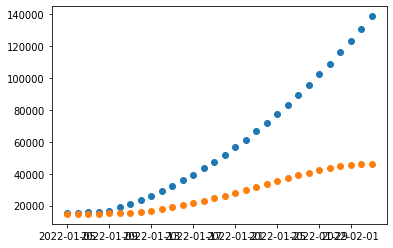

In [110]:
from matplotlib import pyplot as plt
plt.scatter(true_.index, true_.values);
plt.scatter(true_.index, pred_);

In [111]:
early = [127297.73641993303, 132600.20483385914, 136619.37434922362, 140836.80730270335, 143737.04746894058, 142813.11085296664, 142630.53345246712, 143341.5066806572, 143076.48524371465, 146335.75887030794, 146210.0414530263,147364.13578195698, 150360.07855808048, 150905.0310396987, 149520.86527956236, 156450.18866885972, 156425.910736048, 160164.36502176864, 162606.36517775926, 169749.19835550373, 170366.17978586693, 171357.34940489975, 173582.94171802138,174031.0639300036, 177210.84705378467, 178115.14202578535, 181952.4384241183, 180652.69380222203, 181609.9641533312, 178259.66305531352]

In [112]:
cases = get_cases(0)
lags = get_lags(0)

In [113]:
predict = get_predict_linregr("Russia", lags, 30, cases)[0]
predict.size

30

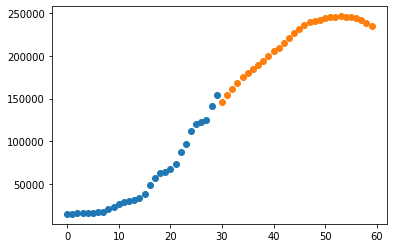

In [114]:
a = cases["Russia"]["history"].iloc[-30:]
plt.scatter(range(0, 30), a.values)
plt.scatter(range(30, 30 + predict.size), list(predict))
plt.show();